In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from numpy.linalg import norm, matrix_power
from functools import reduce
from itertools import product
import time

## for higher order the coefficients are of order 10^24/10^28
B_sign = {3: (np.array([-1,0,1]),2),
          5: (np.array([1,-8,0,8,-1]),12),
          7: (np.array([-1,9,-45,0,45,-9,1]),60),
          9: (np.array([3,-32,168,-672,0,672,-168,32,-3]),840),
          11: (np.array([-2,25,-150,600,-2100,0,2100,-600,150,-25,2]),2520)}

def make_B(N, coefs, cbase):
    """ make matrix B s.t. L = -BB.T with correct zero boundary conditions.
    N - size of B.
    coefs - list of coefficients.
    cbase - divider.
    
    """
    B = np.zeros((N,N))
    l = len(coefs)//2
    diags = list(range(-l,l+1))
    for i,val in zip(diags,coefs):
        B += val*np.eye(N,k=i)

    ### Boundary connditions
    ## left side
    B[0,:] = np.zeros_like(B[0,:])
    B[:,0] = np.zeros_like(B[:,0])
    
    for i in range(l):
        coef_temp = coefs[-(i+1):]
        B[l-i,:len(coef_temp)] = B[l-i,:len(coef_temp)] - coef_temp
        # print(l-i, coef_temp)
    B[:,0] = B[:,0]*np.sqrt(2)

    ## right side
    B[-1,:] = np.zeros_like(B[-1,:])
    B[:,-1] = np.zeros_like(B[:,-1])
    for i in range(l):
        coef_temp = coefs[:(i+1)]
        B[-(l-i)-1,-len(coef_temp):] = B[-(l-i)-1,-len(coef_temp):] - coef_temp
        # print(-(l-i)-1, coef_temp)
    B[:,-1] = B[:,-1]*np.sqrt(2)
    
    # return B
    return B/cbase


In [15]:
l = 2
t = 0.7
c_max = 1
A = 1

Nt = 10
t_list = np.linspace(0,t,Nt)

NQ = 6
nq = NQ - 1

x_real = np.linspace(0,l,2**(nq))
dx = x_real[1]-x_real[0]


num_points_B = [3,5,7,9,11]
acc_order_errors = []

for n_points in num_points_B:
    
    coef_B,cb_B = B_sign[n_points]
    B = make_B(2**(nq),coef_B,cb_B)

    assert len(x_real) == B.shape[0]
    
    H = np.block([[np.zeros_like(B), B],[B.T, np.zeros_like(B)]])
    
    """ Initial conditions (classic) """
    psi_init = A*np.sin(x_real*np.pi/l)
    dpsi_dt_init = np.zeros_like(x_real)
    
    psi_final = A*np.sin(x_real*np.pi/l)*np.cos(c_max*t*np.pi/l) # exact solution
    
    """ Initial conditions (Schrodinger) """
    psi_0_sch = np.concatenate((psi_init, dpsi_dt_init))
    # psi_0_sch /= np.sqrt(np.sum(np.abs(psi_0_sch**2))) # normalization
    
    # plt.figure(figsize=(12,8))
    # color_list = ['r','g','b','y','pink']
    error_list = []
    # for t_i, c in zip(t_list,color_list):
    for t_i in t_list:
        exp_H = expm(-1j*H*t_i/dx)
        psi_sch_final = exp_H@psi_0_sch # numerical solution
        psi_final = A*np.sin(x_real*np.pi/l)*np.cos(c_max*t_i*np.pi/l) # exact solution
    
        # plt.scatter(x_real, psi_final, c=c, marker='x', s=50, alpha=0.7, label = 'Exact')
        # plt.plot(x_real, psi_sch_final[:len(psi_sch_final)//2].real, marker='o', c=c, label = 'Schrodinger', linestyle='dotted')


        error = norm(psi_sch_final[:len(psi_sch_final)//2].real - psi_final)**2
        # print(t_i, error)
        error_list.append(error)
        
    acc_order_errors.append(error_list)
        
    # plt.title('Solution for accuracy order {}. Max error = {:.2E}'.format(acc_order,max(error_list)), fontsize=15)
    # plt.grid()
    # plt.savefig('result_comparison_dalamber_ord_{}.png'.format(acc_order))

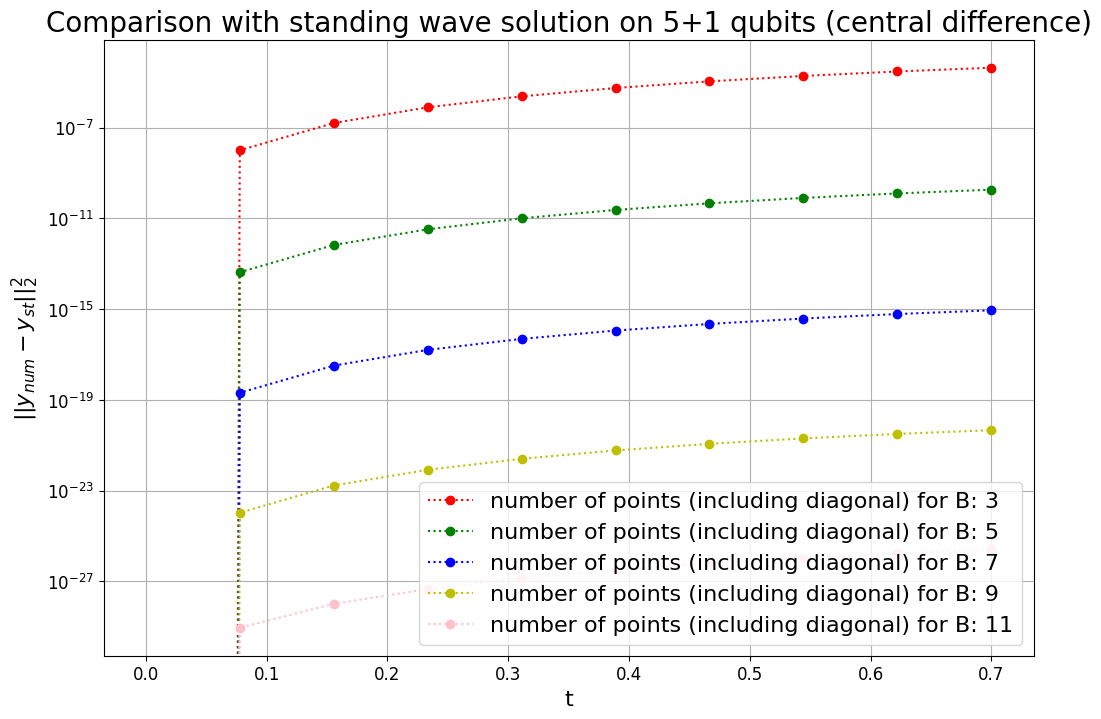

In [16]:
plt.figure(figsize=(12,8))
color_list = ['r','g','b','black','magenta']

for n_points, error_list, c in zip(num_points_B, acc_order_errors, color_list):
        plt.plot(t_list, error_list, marker='o', c=c, label = 'number of points (including diagonal) for B: {}'.format(n_points), linestyle='dotted')
        
plt.title("Comparison with standing wave solution on {}+1 qubits (central difference)".format(nq), fontsize=20)
plt.ylabel('$|| y_{num} - y_{st}||_2^2$', fontsize=16)
plt.xlabel('t', fontsize=16)
plt.yscale('log')
plt.legend(loc='lower right',fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid()
plt.savefig('standing_comparison_error_central_diff_{}_qubits.png'.format(NQ))

## Number of qubits vs Accuracy

In [2]:
l = 2
t = 0.7
c_max = 1
A = 1

Nt = 10
t_list = np.linspace(0,t,Nt)

num_points_B = [3,5,7,9,11]
NQ_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
acc_order_errors = []

for n_points in num_points_B:
    print('{} points'.format(n_points))
    
    coef_B,cb_B = B_sign[n_points]

    error_list = []
    
    for NQ in NQ_list:
        time_start = time.time()
        nq = NQ - 1
        
        if 2**(nq) > n_points:
            x_real = np.linspace(0,l,2**(nq))
            dx = x_real[1]-x_real[0]

            B = make_B(2**(nq),coef_B,cb_B)

            assert len(x_real) == B.shape[0] 

            H = np.block([[np.zeros_like(B), B],[B.T, np.zeros_like(B)]])

            """ Initial conditions (classic) """
            psi_init = A*np.sin(x_real*np.pi/l)
            dpsi_dt_init = np.zeros_like(x_real)

            psi_final = A*np.sin(x_real*np.pi/l)*np.cos(c_max*t*np.pi/l) # exact solution

            """ Initial conditions (Schrodinger) """
            psi_0_sch = np.concatenate((psi_init, dpsi_dt_init))
            # psi_0_sch /= np.sqrt(np.sum(np.abs(psi_0_sch**2))) # normalization

            """ Numerical solution """
            exp_H = expm(-1j*H*t/dx)
            psi_sch_final = exp_H@psi_0_sch # numerical solution

            """ Error """
            error = norm(psi_sch_final[:len(psi_sch_final)//2].real - psi_final)

            time_spend = time.time() - time_start
            print('\t{} qubits || error: {:.2E} || time: {:.3f} s'.format(NQ,error,time_spend))
            error_list.append(error)
        
    acc_order_errors.append(error_list)

3 points
	3 qubits || error: 1.96E-01 || time: 0.888 s
	4 qubits || error: 6.03E-02 || time: 0.003 s
	5 qubits || error: 1.95E-02 || time: 0.001 s
	6 qubits || error: 6.60E-03 || time: 0.002 s
	7 qubits || error: 2.28E-03 || time: 0.007 s
	8 qubits || error: 7.96E-04 || time: 0.026 s
	9 qubits || error: 2.80E-04 || time: 0.139 s
	10 qubits || error: 9.87E-05 || time: 0.852 s
	11 qubits || error: 3.48E-05 || time: 9.586 s
	12 qubits || error: 1.23E-05 || time: 60.066 s
	13 qubits || error: 4.35E-06 || time: 386.979 s


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,8))
color_list = ['r','g','b','black','magenta']
for n_points, error_list, c in zip(num_points_B, acc_order_errors, color_list):
        plt.plot(NQ_list[-len(error_list):], error_list, marker='o', c=c, label = '$\kappa = {}$'.format(n_points), linestyle='dotted')
        
        
plt.title("Comparison with standing wave solution t = {}".format(t), fontsize=20)
plt.ylabel('$|| y_{num} - y_{std}||_2$', fontsize=16)
plt.xlabel('Number of qubits (total)', fontsize=16)
plt.yscale('log')
plt.legend(loc='lower left',fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid()
plt.savefig('standing_comparison_error_qubits-{}.png'.format(NQ_list[-1]))